# Importing packages

In [143]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from tqdm import tqdm

# Relhum conversion functions

In [144]:
def eliq(T):
    a_liq = np.float32(np.array([-0.976195544e-15,-0.952447341e-13,\
                                 0.640689451e-10,\
                      0.206739458e-7,0.302950461e-5,0.264847430e-3,\
                      0.142986287e-1,0.443987641,6.11239921]));
    c_liq = np.float32(-80.0)
    T0 = np.float32(273.16)
    return np.float32(100.0)*np.polyval(a_liq,np.maximum(c_liq,T-T0))

def eice(T):
    a_ice = np.float32(np.array([0.252751365e-14,0.146898966e-11,0.385852041e-9,\
                      0.602588177e-7,0.615021634e-5,0.420895665e-3,\
                      0.188439774e-1,0.503160820,6.11147274]));
    c_ice = np.float32(np.array([273.15,185,-100,0.00763685,0.000151069,7.48215e-07]))
    T0 = np.float32(273.16)
    return np.where(T>c_ice[0],eliq(T),\
                   np.where(T<=c_ice[1],np.float32(100.0)*(c_ice[3]+np.maximum(c_ice[2],T-T0)*\
                   (c_ice[4]+np.maximum(c_ice[2],T-T0)*c_ice[5])),\
                           np.float32(100.0)*np.polyval(a_ice,T-T0)))

def esat(T):
    T0 = np.float32(273.16)
    T00 = np.float32(253.16)
    omtmp = (T-T00)/(T0-T00)
    omega = np.maximum(np.float32(0.0),np.minimum(np.float32(1.0),omtmp))
    return np.where(T>T0,eliq(T),np.where(T<T00,eice(T),(omega*eliq(T)+(1-omega)*eice(T))))

def RH(T,qv,P0,PS,hyam,hybm):
    R = np.float32(287.0)
    Rv = np.float32(461.0)
    p = P0 * hyam + PS[:, None] * hybm # Total pressure (Pa)
    
    T = np.float32(T)
    qv = np.float32(qv)
    p = np.float32(p)
    
    return Rv*p*qv/(R*esat(T))

# Data processing functions

In [164]:
def do_month(month):
    datasets = !ls
    n = str(month)
    datasets = [x for x in datasets if "h1.0000-" + n.zfill(2) in x]
    return xr.open_mfdataset(datasets)

def make_nninput(spData, family, save_diagnostics = False, full_run = False):
    nntbp = np.float32(spData["NNTBP"].values)
    nnqbp = np.float32(spData["NNQBP"].values)
    p0 = np.float32(spData["P0"].values)
    ps = np.float32(spData["NNPS"].values)
    hyam = np.float32(spData["hyam"].values)
    hybm = np.float32(spData["hybm"].values)
    relhum = np.float32(spData["RELHUM"].values)
    tphystnd = np.float32(spData["TPHYSTND"].values)
    phq = np.float32(spData["PHQ"].values)

    p0 = np.float32(np.array(list(set(p0))))
    print("loaded in data")
    newhum = np.float32(np.zeros((spData["time"].shape[0],\
                                  spData["lev"].shape[0], \
                                  spData["lat"].shape[0], \
                                  spData["lon"].shape[0])))
    lats = spData["lat"]
    lons = spData["lon"]
    print("starting for loop")
    for i in tqdm(range(len(lats))):
        for j in range(len(lons)):
            latIndex = i
            lonIndex = j
            R = np.float32(287.0)
            Rv = np.float32(461.0)
            p = np.float32(p0 * hyam + ps[:, None, latIndex, lonIndex] * hybm) # Total pressure (Pa)
            T = np.float32(nntbp[:, :, latIndex, lonIndex])
            qv = np.float32(nnqbp[:, :, latIndex, lonIndex])
            p = np.float32(p)
            newhum[:,:, latIndex, lonIndex] = np.float32(Rv*p*qv/(R*esat(T)))
    
    nntbp = np.float32(np.moveaxis(nntbp[1:,:,:,:],0,1))
    print("nntbp")
    print(nntbp.shape)
    
    nnqbp = np.float32(np.moveaxis(nnqbp[1:,:,:,:],0,1))
    print("nnqbp")
    print(nnqbp.shape)
    
    lhflx = np.float32(spData["LHFLX"].values[np.newaxis,:-1,:,:])
    print("lhflx")
    print(lhflx.shape)
    
    shflx = np.float32(spData["SHFLX"].values[np.newaxis,:-1,:,:])
    print("shflx")
    print(shflx.shape)
    
    ps = np.float32(spData["NNPS"].values[np.newaxis,1:,:,:])
    print("ps")
    print(ps.shape)
    
    solin = np.float32(spData["SOLIN"].values[np.newaxis,1:,:,:])
    print("solin")
    print(solin.shape)
    
    newhum = np.float32(np.moveaxis(newhum[1:,:,:,:],0,1))
    print("newhum")
    print(newhum.shape)
    
    oldhum = np.float32(np.moveaxis(relhum[1:,:,:,:],0,1))
    print("oldhum")
    print(oldhum.shape)
    
    tphystnd = np.float32(np.moveaxis(tphystnd[1:,:,:,:],0,1))
    print("tphystnd")
    print(tphystnd.shape)
    
    phq = np.float32(np.moveaxis(phq[1:,:,:,:],0,1))
    print("phq")
    print(phq.shape)
        
    if family == "specific":
        nnInput = np.float32(np.concatenate((nntbp, \
                                             nnqbp, \
                                             ps, \
                                             solin, \
                                             shflx, \
                                             lhflx)))
        
        nnTarget = np.float32(np.concatenate((tphystnd, phq)))
    
    elif family == "relative":
        nnInput = np.float32(np.concatenate((nntbp, \
                                         newhum, \
                                         ps, \
                                         solin, \
                                         shflx, \
                                         lhflx)))
                             
        nnTarget = np.float32(np.concatenate((tphystnd, phq)))
    
    if full_run:
        nnInput = nnInput[:,:-1,:,:] #the last timestep of a run can have funky values
        nnTarget = nnTarget[:,:-1,:,:] #the last timestep of a run can have funky values
    
    print("nnInput")
    nnInput.shape
    
    print("nnTarget")
    nnTarget.shape
    
    errors = (newhum-oldhum/100).flatten()
    result = "Mean relative humidity conversion error: " + str(np.mean(errors)) + "\n"
    result = result + "Variance for relative humidity conversion error: " + str(np.var(errors)) + "\n"
    result = result + "nntbp.shape: " + str(nntbp.shape) + "\n"
    result = result + "nnqbp.shape: " + str(nnqbp.shape) + "\n"
    result = result + "lhflx.shape: " + str(lhflx.shape) + "\n"
    result = result + "shflx.shape: " + str(shflx.shape) + "\n"
    result = result + "ps.shape: " + str(ps.shape) + "\n"
    result = result + "solin.shape: " + str(solin.shape) + "\n"
    result = result + "newhum.shape: " + str(newhum.shape) + "\n"
    result = result + "oldhum.shape: " + str(oldhum.shape) + "\n"
    result = result + "tphystnd.shape: " + str(tphystnd.shape) + "\n"
    result = result + "phq.shape: " + str(phq.shape) + "\n"
    result = result + "nnInput.shape: " + str(nnInput.shape) + "\n"
    print(result)

    if save_diagnostics:
        diagnostics = 'diagnostics_' + str(month) + '.txt'
        with open(diagnostics, 'a') as fp:
            fp.write(result)
    
    return nnInput, nnTarget

def combine_arrays(*args, contiguous = True):
    if contiguous: # meaning each spData was part of the same run
        return np.concatenate((args), axis = 1)[:,:-1,:,:]
    return(np.concatenate((args), axis = 1))
                         
def sample_indices(size, spacing, fixed = True):
    numIndices = np.round(size/spacing)
    if fixed:
        indices = np.array([int(x) for x in np.round(np.linspace(1,size,int(numIndices)))])-1
    else:
        indices = list(range(size))
        np.random.shuffle(indices)
        indices = indices[0:int(numIndices)]
    return indices

def reshape_input(nnData, subsample = False, spacing = 5):
    if subsample:
        nnData = nnData[:,:,:,sampleIndices(nnData.shape[3], spacing, True)]
    nnData = nnData.ravel(order = 'F').reshape(64,-1,order = 'F')
    return nnData

def reshape_target(nnData, subsample = False, spacing = 5):
    if subsample:
        nnData = nnData[:,:,:,sampleIndices(nnData.shape[3], spacing, True)]
    nnData = nnData.ravel(order = 'F').reshape(60,-1,order = 'F')
    return nnData

def normalize_input_train(X, family, reshaped = True, normalization = "standard", save_files = False):
    
    # specific heat of air = 1004 J/ K / kg
    # latent heat of vaporization 2.5*10^6

    heatScale = 1004
    moistScale = 2.5e6
    
    if reshaped:
        X = X.transpose()
        split_index = int(X.shape[0]*split)
        X_train, X_val = X[:split_index,:], X[split_index:,:]
        del X
        print("X_train shape: ")
        print(X_train.shape)
        print("X_val shape: ")
        print(X_val.shape)

    train_mu = np.mean(X_train, axis = 0)[:, np.newaxis]
    train_std = np.std(X_train, axis = 0)[:, np.newaxis]
    train_min = X_train.min(axis = 0)[:, np.newaxis]
    train_max = X_train.max(axis = 0)[:, np.newaxis]
    
    if normalization == "standard":
        inpsub = train_mu
        inpdiv = train_std
        
    elif normalization == "range":
        inpsub = train_min
        inpdiv = train_max - train_min
        
    norms_input = [inpsub, inpdiv]
    
    print("INP_SUB shape: ")
    print(inpsub.shape)
    print("INP_DIV shape: ")
    print(inpdiv.shape)
    
    norm_xtrain = (X_train.transpose() - inpsub)/inpdiv
    norm_xtrain = norm_xtrain.transpose()
    norm_xtest = (X_test.transpose() - inpsub)/inpdiv
    norm_xtest = norm_xtest.transpose()
    
    print("norm X_train shape: ")
    print(norm_xtrain.shape)
    print("norm X_test shape: ")
    print(norm_xtest.shape)
    
    return [[norm_xtrain, norm_xtest], norms_input]

def normalize_target_train(y, family, reshaped = True, normalization = "standard", save_files = False):
    
    # specific heat of air = 1004 J/ K / kg
    # latent heat of vaporization 2.5*10^6

    heatScale = 1004
    moistScale = 2.5e6
    
    print("y_train shape: ")
    print(y_train.shape)
    print("y_test shape: ")
    print(y_test.shape)

    outscale = np.concatenate((np.repeat(heatScale, 30), np.repeat(moistScale, 30)))
    
    if normalization == "standard":
        inpsub = train_mu
        inpdiv = train_std
        
    elif normalization == "range":
        inpsub = train_min
        inpdiv = train_max - train_min
        
    norms_output = outscale
    
    print("INP_SUB shape: ")
    print(inpsub.shape)
    print("INP_DIV shape: ")
    print(inpdiv.shape)
    print("outscale shape: ")
    print(outscale.shape)
    
    norm_ytrain[:, 0:30] = norm_ytrain[:, 0:30]*outscale[0:30]
    norm_ytrain[:, 30:60] = norm_ytrain[:, 30:60]*outscale[30:60]
    
    norm_ytest[:, 0:30] = norm_ytest[:, 0:30]*outscale[0:30]
    norm_ytest[:, 30:60] = norm_ytest[:, 30:60]*outscale[30:60]
    
    print("norm y_train shape: ")
    print(norm_ytrain.shape)
    print("norm y_test shape: ")
    print(norm_ytest.shape)
    
    return [[norm_ytrain, norm_ytest], norms_output]

def prepare_ingredients32(variation, files, path = "./"):
    if variation == 0:
        path = path + "specific/"
    if variation == 1:
        path = path + "relative/"
    with open(path + "trainInput.npy", 'wb') as f:
        np.save(f, np.float32(files[1][0]))
    with open(path + "testInput.npy", 'wb') as f:
        np.save(f, np.float32(files[1][1]))
    with open(path + "trainOutput.npy", 'wb') as f:
        np.save(f, np.float32(files[1][2]))
    with open(path + "testOutput.npy", 'wb') as f:
        np.save(f, np.float32(files[1][3]))
    np.savetxt(path + "normalization/inp_sub.txt", np.float32(files[2][0]), delimiter=',')
    np.savetxt(path + "normalization/inp_div.txt", np.float32(files[2][1]), delimiter=',')
    np.savetxt(path + "normalization/out_scale.txt", np.float32(files[2][2]), delimiter=',')
    


In [146]:
nnInput_10, nnTarget_10 = make_nninput(do_month(10), "relative")
nnInput_11, nnTarget_11 = make_nninput(do_month(11), "relative")

unshaped_input = combine_arrays(nnInput_10, nnInput_11)
unshaped_target = combine_arrays(nnTarget_10, nnTarget_11)

reshaped_input = reshape_input(combine_arrays(nnInput_10, nnInput_11))
reshaped_target = reshape_target(combine_arrays(nnTarget_10, nnTarget_11))

loaded in data
starting for loop


100%|████████████████████████████████████████████████████████████████████████████| 64/64 [00:05<00:00, 11.75it/s]


nntbp
(30, 95, 64, 128)
nnqbp
(30, 95, 64, 128)
lhflx
(1, 95, 64, 128)
shflx
(1, 95, 64, 128)
ps
(1, 95, 64, 128)
solin
(1, 95, 64, 128)
newhum
(30, 95, 64, 128)
oldhum
(30, 95, 64, 128)
tphystnd
(30, 95, 64, 128)
phq
(30, 95, 64, 128)
nnInput
nnTarget
Mean relative humidity conversion error: 0.0043063145
Variance for relative humidity conversion error: 0.00047256332
nntbp.shape: (30, 95, 64, 128)
nnqbp.shape: (30, 95, 64, 128)
lhflx.shape: (1, 95, 64, 128)
shflx.shape: (1, 95, 64, 128)
ps.shape: (1, 95, 64, 128)
solin.shape: (1, 95, 64, 128)
newhum.shape: (30, 95, 64, 128)
oldhum.shape: (30, 95, 64, 128)
tphystnd.shape: (30, 95, 64, 128)
phq.shape: (30, 95, 64, 128)
nnInput.shape: (64, 95, 64, 128)

loaded in data
starting for loop


100%|████████████████████████████████████████████████████████████████████████████| 64/64 [00:05<00:00, 11.59it/s]


nntbp
(30, 95, 64, 128)
nnqbp
(30, 95, 64, 128)
lhflx
(1, 95, 64, 128)
shflx
(1, 95, 64, 128)
ps
(1, 95, 64, 128)
solin
(1, 95, 64, 128)
newhum
(30, 95, 64, 128)
oldhum
(30, 95, 64, 128)
tphystnd
(30, 95, 64, 128)
phq
(30, 95, 64, 128)
nnInput
nnTarget
Mean relative humidity conversion error: 0.0041737375
Variance for relative humidity conversion error: 0.00046795444
nntbp.shape: (30, 95, 64, 128)
nnqbp.shape: (30, 95, 64, 128)
lhflx.shape: (1, 95, 64, 128)
shflx.shape: (1, 95, 64, 128)
ps.shape: (1, 95, 64, 128)
solin.shape: (1, 95, 64, 128)
newhum.shape: (30, 95, 64, 128)
oldhum.shape: (30, 95, 64, 128)
tphystnd.shape: (30, 95, 64, 128)
phq.shape: (30, 95, 64, 128)
nnInput.shape: (64, 95, 64, 128)



In [147]:
unshaped_input.shape

(64, 189, 64, 128)

In [148]:
unshaped_target.shape

(60, 189, 64, 128)

In [149]:
reshaped_input.shape

(64, 1548288)

In [150]:
reshaped_target.shape

(60, 1548288)

In [180]:
def normalize_input(X_train, family, reshaped = True, normalization = "standard", split = .8):
    
    # specific heat of air = 1004 J/ K / kg
    # latent heat of vaporization 2.5*10^6

    heatScale = 1004
    moistScale = 2.5e6
    
    if reshaped:
        
        train_mu = np.mean(X_train, axis = 1)[:, np.newaxis]
        train_std = np.std(X_train, axis = 1)[:, np.newaxis]
        train_min = X_train.min(axis = 1)[:, np.newaxis]
        train_max = X_train.max(axis = 1)[:, np.newaxis]
        
        return X_train, train_mu, train_std, train_min, train_max
        
        if normalization == "standard":
            inpsub = train_mu
            inpdiv = train_std
        
        elif normalization == "range":
            inpsub = train_min
            inpdiv = train_max - train_min
        
        print("INP_SUB shape: ")
        print(inpsub.shape)
        print("INP_DIV shape: ")
        print(inpdiv.shape)
        
        #normalizing
        X_train = ((X_train.transpose() - inpsub)/inpdiv).transpose()
        X_val = ((X_val.transpose() - inpsub)/inpdiv).transpose()

        print("X_train shape: ")
        print(X_train.shape)
        print("X_val shape: ")
        print(X_val.shape)
        return X_train
    
    else:

        train_mu = np.mean(X_train, axis = (1,2,3))[:, np.newaxis]
        train_std = np.std(X_train, axis = (1,2,3))[:, np.newaxis]
        train_min = X_train.min(axis = (1,2,3))[:, np.newaxis]
        train_max = X_train.max(axis = (1,2,3))[:, np.newaxis]
        
        return X_train, train_mu, train_std, train_min, train_max
    
    return X_train, inpsub, inpdiv



In [196]:
X_train_1, mean_1, std_1, min_1, max_1 = normalize_input(reshaped_input, family = "relative", reshaped = True)
X_train_2, mean_2, std_2, min_2, max_2 = normalize_input(unshaped_input, family = "relative", reshaped = False)

In [197]:
unshaped_input.shape

(64, 189, 64, 128)

In [198]:
X_train_1.shape

(64, 1548288)

In [199]:
mean_1.shape

(64, 1)

In [200]:
std_1.shape

(64, 1)

In [201]:
min_1.shape

(64, 1)

In [202]:
max_1.shape

(64, 1)

In [203]:
X_train_2.shape

(64, 189, 64, 128)

In [204]:
mean_2.shape

(64, 1)

In [205]:
std_1.shape

(64, 1)

In [206]:
min_2.shape

(64, 1)

In [207]:
max_2.shape

(64, 1)

In [214]:
np.array_equal(mean_1, mean_2)

False

In [299]:
lol_1.ravel(order = 'F').reshape(2,-1, order = 'F')

array([[4, 4, 4, 3, 5, 2, 1, 1, 1, 2, 1, 9],
       [9, 9, 2, 3, 6, 3, 4, 9, 6, 2, 7, 9]])

In [331]:
lol_1 = np.array([[[[4,1],[3,2]],[[4,1],[5,1]],[[4,1],[2,9]]],[[[9,4],[3,2]],[[9,9],[6,7]],[[2,6],[3,9]]]])
lol_2 = lol_1.ravel(order = 'F').reshape(2,-1,order = 'F')
assert(np.array_equal(np.mean(lol_1, axis = (1,2,3))[:, np.newaxis], np.mean(lol_2, axis = 1)[:, np.newaxis]))

In [357]:
family = "specific"

nnInput_10, nnTarget_10 = make_nninput(do_month(10), family)
nnInput_11, nnTarget_11 = make_nninput(do_month(11), family)

unshaped_input = combine_arrays(nnInput_10, nnInput_11)
unshaped_target = combine_arrays(nnTarget_10, nnTarget_11)

reshaped_input = reshape_input(combine_arrays(nnInput_10, nnInput_11))
reshaped_target = reshape_target(combine_arrays(nnTarget_10, nnTarget_11))

# assert(np.array_equal(np.mean(case_A, axis = (1,2,3), dtype=np.float64)[:, np.newaxis], \
#                       np.mean(case_B, axis = 1, dtype=np.float64)[:, np.newaxis]))

loaded in data
starting for loop


100%|████████████████████████████████████████████████████████████████████████████| 64/64 [00:03<00:00, 18.13it/s]


nntbp
(30, 95, 64, 128)
nnqbp
(30, 95, 64, 128)
lhflx
(1, 95, 64, 128)
shflx
(1, 95, 64, 128)
ps
(1, 95, 64, 128)
solin
(1, 95, 64, 128)
newhum
(30, 95, 64, 128)
oldhum
(30, 95, 64, 128)
tphystnd
(30, 95, 64, 128)
phq
(30, 95, 64, 128)
nnInput
nnTarget
Mean relative humidity conversion error: 0.0043063145
Variance for relative humidity conversion error: 0.00047256332
nntbp.shape: (30, 95, 64, 128)
nnqbp.shape: (30, 95, 64, 128)
lhflx.shape: (1, 95, 64, 128)
shflx.shape: (1, 95, 64, 128)
ps.shape: (1, 95, 64, 128)
solin.shape: (1, 95, 64, 128)
newhum.shape: (30, 95, 64, 128)
oldhum.shape: (30, 95, 64, 128)
tphystnd.shape: (30, 95, 64, 128)
phq.shape: (30, 95, 64, 128)
nnInput.shape: (64, 95, 64, 128)

loaded in data
starting for loop


100%|████████████████████████████████████████████████████████████████████████████| 64/64 [00:03<00:00, 17.55it/s]


nntbp
(30, 95, 64, 128)
nnqbp
(30, 95, 64, 128)
lhflx
(1, 95, 64, 128)
shflx
(1, 95, 64, 128)
ps
(1, 95, 64, 128)
solin
(1, 95, 64, 128)
newhum
(30, 95, 64, 128)
oldhum
(30, 95, 64, 128)
tphystnd
(30, 95, 64, 128)
phq
(30, 95, 64, 128)
nnInput
nnTarget
Mean relative humidity conversion error: 0.0041737375
Variance for relative humidity conversion error: 0.00046795444
nntbp.shape: (30, 95, 64, 128)
nnqbp.shape: (30, 95, 64, 128)
lhflx.shape: (1, 95, 64, 128)
shflx.shape: (1, 95, 64, 128)
ps.shape: (1, 95, 64, 128)
solin.shape: (1, 95, 64, 128)
newhum.shape: (30, 95, 64, 128)
oldhum.shape: (30, 95, 64, 128)
tphystnd.shape: (30, 95, 64, 128)
phq.shape: (30, 95, 64, 128)
nnInput.shape: (64, 95, 64, 128)



In [414]:
case_A = unshaped_input
case_B = unshaped_input.ravel(order = 'F').reshape(64,-1,order = 'F')
case_C = unshaped_input.reshape(64,-1,order = 'F')

case_A_mean = np.mean(case_A, axis = (1,2,3))[:, np.newaxis]
case_B_mean = np.mean(case_B, axis = 1)[:, np.newaxis]
case_C_mean = np.mean(case_C, axis = 1)[:, np.newaxis]

print(np.array_equal(case_A_mean, case_B_mean))
print(np.array_equal(case_A_mean, case_C_mean))

False
False


(array([63.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ -1.2761536,  15.254587 ,  31.785328 ,  48.316067 ,  64.84681  ,
         81.37755  ,  97.90829  , 114.439026 , 130.96977  , 147.5005   ,
        164.03125  ], dtype=float32),
 <BarContainer object of 10 artists>)

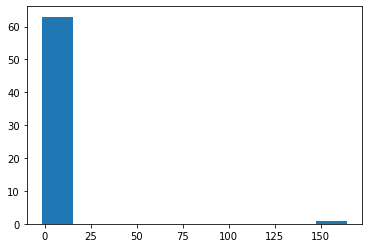

In [416]:
plt.hist(case_A_mean-case_B_mean)

(array([63.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ -1.2761536,  15.254587 ,  31.785328 ,  48.316067 ,  64.84681  ,
         81.37755  ,  97.90829  , 114.439026 , 130.96977  , 147.5005   ,
        164.03125  ], dtype=float32),
 <BarContainer object of 10 artists>)

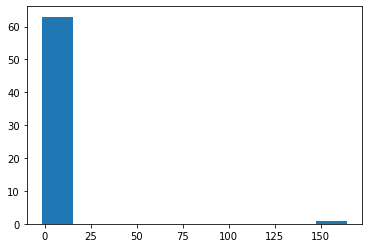

In [417]:
plt.hist(case_A_mean-case_C_mean)

In [363]:
case_A_mean.shape, case_B_mean.shape

((64, 1), (64, 1))

In [364]:
case_A.shape

(64, 189, 64, 128)

In [365]:
case_B.shape

(64, 1548288)

In [366]:
case_A[0,:,:,:].shape

(189, 64, 128)

In [367]:
case_B[0].shape

(1548288,)

In [368]:
189*64*128

1548288

In [369]:
case_A_mean[0]

array([225.70236], dtype=float32)

In [370]:
case_B_mean[0]

array([224.9265], dtype=float32)

In [374]:
case_A[0,:,:,:].flatten().shape

(1548288,)

In [375]:
case_B[0].shape

(1548288,)

In [376]:
np.array_equal(case_A[0,:,:,:], case_B[0])

False

In [403]:
unshaped_input.ravel(order = 'F').shape

(99090432,)

In [395]:
for i in range(64):
    print(np.mean(case_A[i,:,:,:].flatten())-np.mean(case_B[i]))

0.0
0.00015258789
1.5258789e-05
-9.1552734e-05
-1.5258789e-05
-6.1035156e-05
-0.00010681152
9.1552734e-05
-6.1035156e-05
-0.0001373291
1.5258789e-05
-6.1035156e-05
3.0517578e-05
-7.6293945e-05
-9.1552734e-05
0.0
0.0
0.0
-1.5258789e-05
0.0
-9.1552734e-05
3.0517578e-05
6.1035156e-05
-6.1035156e-05
9.1552734e-05
-6.1035156e-05
0.0
0.0
6.1035156e-05
-3.0517578e-05
0.0
-1.1368684e-13
-1.1368684e-13
-3.410605e-13
1.1368684e-13
0.0
0.0
-4.5474735e-13
-1.1368684e-13
2.2737368e-13
-2.2737368e-13
-1.8189894e-12
3.637979e-12
-1.4551915e-11
0.0
1.0186341e-10
5.820766e-11
5.820766e-11
-5.820766e-11
9.313226e-10
2.3283064e-10
-1.3969839e-09
0.0
-1.3969839e-09
1.8626451e-09
-4.656613e-10
-4.656613e-10
-4.656613e-10
-4.656613e-10
2.7939677e-09
0.03125
-6.1035156e-05
-1.9073486e-06
-3.8146973e-05


In [397]:
for i in range(64):
    print(case_A_mean[i]-case_B_mean[i])

[0.77586365]
[-0.4254303]
[-0.07002258]
[-1.1116638]
[-0.17292786]
[0.51597595]
[0.17807007]
[-0.13746643]
[0.12106323]
[0.73384094]
[0.33955383]
[-0.34683228]
[-1.1111755]
[0.26286316]
[-0.28207397]
[-1.2605896]
[-0.00090027]
[1.2856903]
[0.53837585]
[-1.2761536]
[-1.1069031]
[0.44256592]
[1.0859985]
[1.1465149]
[0.95303345]
[1.3720398]
[1.4955139]
[1.4616394]
[1.1854553]
[0.37545776]
[3.2963499e-09]
[1.6509603e-09]
[4.2189185e-10]
[-2.2436097e-09]
[-1.0736585e-09]
[-2.433012e-09]
[-1.1026486e-09]
[1.8383162e-10]
[-1.8064839e-09]
[-7.1272552e-09]
[-2.6775524e-09]
[-2.6869202e-08]
[-1.1041266e-09]
[-5.1881216e-08]
[-6.70334e-08]
[4.5605702e-08]
[-4.1676685e-08]
[9.5693395e-08]
[-1.314329e-07]
[-2.392335e-07]
[1.4458783e-07]
[-4.7823414e-07]
[7.4878335e-07]
[-1.3178214e-07]
[1.8342398e-06]
[-4.596077e-07]
[-9.0617687e-07]
[-2.9411167e-06]
[-1.2707897e-06]
[3.2894313e-06]
[164.03125]
[0.04660034]
[-0.00092316]
[0.0013504]


In [393]:
np.mean(case_A[0,:,:,:])

225.70236

In [380]:
np.mean(case_B[0])

225.70236

In [382]:
case_A_mean[0]

array([225.70236], dtype=float32)

In [383]:
case_B_mean[0]

array([224.9265], dtype=float32)

In [384]:
np.mean(case_B, axis = 1)[:,np.newaxis][0]

array([224.9265], dtype=float32)

In [387]:
np.mean(case_B, axis = 1).shape

(64,)

In [401]:
case_B[30:60].flatten().min()

2.5286658e-08

(array([4., 4., 5., 2., 1., 1., 1., 6., 3., 3.]),
 array([9.0026855e-04, 1.5036163e-01, 2.9982299e-01, 4.4928437e-01,
        5.9874570e-01, 7.4820709e-01, 8.9766848e-01, 1.0471299e+00,
        1.1965911e+00, 1.3460525e+00, 1.4955139e+00], dtype=float32),
 <BarContainer object of 10 artists>)

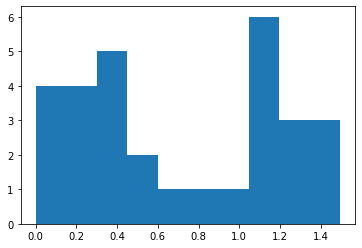

In [361]:
plt.hist(np.abs(case_A_mean[0:30] - case_B_mean[0:30]))

(array([22.,  2.,  2.,  1.,  0.,  1.,  0.,  0.,  1.,  1.]),
 array([1.8383162e-10, 3.2910859e-07, 6.5803334e-07, 9.8695807e-07,
        1.3158829e-06, 1.6448075e-06, 1.9737324e-06, 2.3026571e-06,
        2.6315818e-06, 2.9605067e-06, 3.2894313e-06], dtype=float32),
 <BarContainer object of 10 artists>)

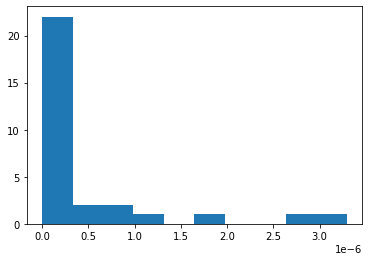

In [360]:
plt.hist(np.abs(case_A_mean[30:60] - case_B_mean[30:60]))

In [336]:
np.mean(case_B[0])

225.70236

In [326]:
case_A_mean[1]

array([218.84981], dtype=float32)

In [327]:
case_B_mean[1]

array([219.27524], dtype=float32)

In [321]:
case_B_mean = np.mean(case_B, axis = 1)[:,np.newaxis]

In [270]:
lol_2

array([[4, 4, 4, 3, 5, 2, 1, 1, 1, 2, 1, 9],
       [9, 9, 2, 3, 6, 3, 4, 9, 6, 2, 7, 9]])

In [273]:
np.mean(lol_1, axis = (1,2,3))[:, np.newaxis]

array([[3.08333333],
       [5.75      ]])

In [274]:
np.mean(lol_2, axis = 1)[:, np.newaxis]

array([[3.08333333],
       [5.75      ]])

In [275]:
np.std(lol_1, axis = (1,2,3))[:, np.newaxis]

array([[2.25308431],
       [2.74241378]])

In [276]:
np.std(lol_2, axis = 1)[:, np.newaxis]

array([[2.25308431],
       [2.74241378]])

In [228]:
lol_1.min(axis = (1,2))

array([1, 2])

In [234]:
lol_2.min(axis = 1)

array([1, 2])

In [235]:
lol_1.max(axis = (1,2))

array([9, 9])

In [236]:
lol_2.max(axis = 1)

array([9, 9])

In [329]:
np.mean(lol_1, axis = (1,2))

array([[3.66666667, 2.5       ],
       [5.33333333, 6.16666667]])

In [227]:
np.array_equal(lol_1, lol_2)

False

In [328]:
np.array_equal(mean_1, mean_2)

False

# run the code

In [ ]:
#saveNNInput(1)

In [ ]:
#saveNNInput(2)

In [ ]:
#saveNNInput(3)

In [ ]:
#saveNNInput(4)

In [ ]:
#saveNNInput(5)